In [1]:
import plotly
import matplotlib.pyplot as plt
import plotly.express as px
import json
import numpy as np
import pandas as pd

In [2]:
V = lambda l,b,g,x: l*np.cos(x)-l+2*(sigma(l,b,g)-1)*np.log(1+np.cos(x))-2*sigma(l,b,g)*np.log(3-np.cos(x)+4*np.sin(x/2))
sigma = lambda l,b,g: b*g/np.sqrt(l)
PvvV0 = lambda l,b,g: l+1
PuuV0 = lambda l,b,g: 1-l
PuV0 = lambda l,b,g: -2*sigma(l,b,g)
PvvV1 = lambda l,b,g: l+np.sqrt(2)*sigma(l,b,g)+2
PuuV1 = lambda l,b,g: 1/np.cos(np.pi/5)**2+sigma(l,b,g)*np.tan(np.pi/5)*1/np.cos(np.pi/5)-l*np.cos(2*np.pi/5)
PuV1 = lambda l,b,g: -2*np.tan(np.pi/5)-2*sigma(l,b,g)*1/np.cos(np.pi/5)+l*np.sin(2*np.pi/5)
V0 = lambda l,b,g: -2 * np.log(2)
V1 = lambda l,b,g: V(l,b,g,-2*np.pi/5)

apex0 = lambda l,b,g: -PuV0(l,b,g)/PuuV0(l,b,g)
Vapex0 = lambda l,b,g: V0(l,b,g)-PuV0(l,b,g)**2/(2*PuuV0(l,b,g))
apex1 = lambda l,b,g: -PuV1(l,b,g)/PuuV1(l,b,g)-2*np.pi/5
Vapex1 = lambda l,b,g: V1(l,b,g)-PuV1(l,b,g)**2/(2*PuuV1(l,b,g))
k = lambda l,b,g: (Vapex0(l,b,g)-Vapex1(l,b,g))/(apex0(l,b,g)-apex1(l,b,g))

def analytic_time3(l,b,g):
    term1factor = g/k(l,b,g)*np.sqrt(PvvV0(l,b,g)/PvvV1(l,b,g))*(np.exp((Vapex0(l,b,g)-Vapex1(l,b,g))/g**2)-1)
    term1inner = np.sqrt(np.pi/(2*PuuV1(l,b,g)))+np.sqrt(-np.pi/(2*PuuV0(l,b,g)))+g/k(l,b,g)
    term2factor = np.sqrt(PvvV0(l,b,g)/PvvV1(l,b,g))
    term2inner = np.pi/(2*np.sqrt(-PuuV0(l,b,g)*PuuV1(l,b,g)))-1/k(l,b,g)*(apex0(l,b,g)-apex1(l,b,g))
    return term1factor*term1inner+term2factor*term2inner

def analytic_time4(l,b,g):
    C = 2*np.pi*np.sqrt(
        (l + 1) /
        ((l - 1) * (2 * l - 2 + g * b * np.sqrt(l - 1)) * (2 * l + g * b * np.sqrt(l - 1)))
    )
    DeltaV = -4*g*b/np.sqrt(l)*np.arcsin(np.sqrt(1-1/l))+2*(l-1)-2*np.log(l)
    return np.exp(DeltaV/g**2)*C

In [3]:
def aggregate(data, keep_keys):
    agg = {}
    for data_ptr in data:
        key = tuple([data_ptr[key] for key in keep_keys])
        percent_err = data_ptr['log_err']
        if key not in agg:
            agg[key] = np.array([percent_err, 1])
        else:
            agg[key] += np.array([percent_err, 1])
    keys = list(agg.keys())
    vals = [agg[key][0]/agg[key][1] for key in keys]
    keys = [[key[i] for key in keys] for i in range(len(keep_keys))]
    return *keys, vals

In [4]:
def process_data(data):
    for data_ptr in data:
        data_ptr['err_fit1'] = abs(np.log(data_ptr["sim_fit_time"]) -  np.log(data_ptr["sol1_time"])) / (data_ptr["sim_fit_time"]+1e-9) * 100
        data_ptr['err_fit3'] = abs(np.log(data_ptr["sim_fit_time"]) -  np.log(data_ptr["sol3_time"])) / (data_ptr["sim_fit_time"]+1e-9) * 100
        data_ptr['log_sim_fit_time'] = np.log(data_ptr["sim_fit_time"])
        data_ptr['log_sol1_time'] = np.log(data_ptr["sol1_time"])
        data_ptr['log_sol3_time'] = np.log(data_ptr["sol3_time"])
        data_ptr['log_err_fit1'] = abs((data_ptr['log_sim_fit_time'] - data_ptr['log_sol1_time']) / (data_ptr['log_sim_fit_time']+1e-9)) * 100
        data_ptr['log_err_fit3'] = abs((data_ptr['log_sim_fit_time'] - data_ptr['log_sol3_time']) / (data_ptr['log_sim_fit_time']+1e-9)) * 100
        data_ptr['sol4_time'] = analytic_time4(data_ptr['lambda'], data_ptr['b'], data_ptr['g'])
    return data

/var/folders/z6/fmr1p2mn2xvg89jdw6vbwb7w0000gq/T/ipykernel_71383/3383366786.py:64: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000)


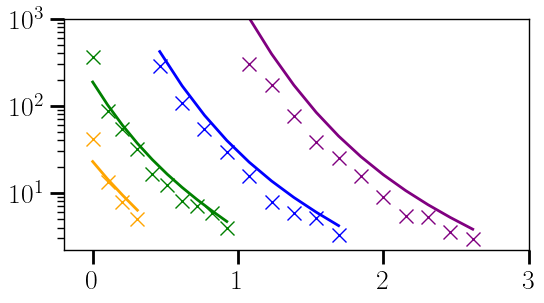

In [7]:
with open('g4-1l15-2brange.json') as f:
    datal15 = json.load(f)
with open('g4-1l2brange.json') as f:
    datal2 = json.load(f)
with open('g4-1l25-1brange.json') as f:
    datal25 = json.load(f)
with open('g4-1l3brange.json') as f:
    datal3 = json.load(f)

datal15 = process_data(datal15)
datal2 = process_data(datal2)
datal25 = process_data(datal25)
datal3 = process_data(datal3)

df15 = pd.DataFrame(datal15)
df2 = pd.DataFrame(datal2)
df25 = pd.DataFrame(datal25)
df3 = pd.DataFrame(datal3)

from matplotlib import rc
rc('text', usetex=True)

plt.rcParams.update({
    'lines.linewidth': 2,       # Line thickness
    'lines.markersize': 10,     # Marker size
    'axes.linewidth': 1,        # Border thickness for axes
    'axes.titlesize': 20,       # Title font size
    'axes.labelsize': 20,       # Label font size
    'xtick.labelsize': 20,      # X-axis tick label font size
    'ytick.labelsize': 20,      # Y-axis tick label font size
    'xtick.major.size': 10,     # Length of X-axis ticks
    'xtick.major.width': 2,
    'xtick.minor.size': 5,     # Length of X-axis ticks
    'xtick.minor.width': 1,
    'ytick.major.size': 10,     # Length of X-axis ticks
    'ytick.major.width': 2,
    'ytick.minor.size': 5,     # Length of X-axis ticks
    'ytick.minor.width': 1,
    'legend.fontsize': 20,      # Legend font size
    'legend.frameon': True,     # Enable legend frame
    'legend.framealpha': 0.9,   # Legend frame transparency
    'legend.edgecolor': 'black', # Legend frame border color
})

plt.figure(figsize=(6, 3))
plt.plot(df15['b'], df15['sim_fit_time'], 'x', markerfacecolor='orange', markeredgecolor='orange', label=r"$\lambda=1.5$")
plt.plot(df15['b'], df15['sol3_time'], color='orange')

plt.plot(df2['b'], df2['sim_fit_time'], 'x', markerfacecolor='green', markeredgecolor='green', label=r"$\lambda=2$")
plt.plot(df2['b'], df2['sol3_time'], color='green')

plt.plot(df25['b'], df25['sim_fit_time'], 'x', markerfacecolor='blue', markeredgecolor='blue', label=r"$\lambda=2.5$")
plt.plot(df25['b'], df25['sol3_time'], color='blue')

plt.plot(df3['b'], df3['sim_fit_time'], 'x', markerfacecolor='purple', markeredgecolor='purple', label=r"$\lambda=3$")
plt.plot(df3['b'], df3['sol3_time'], color='purple')


plt.yscale('log')
#plt.ylabel(r'\textit{time}')
#plt.xlabel(r'\textit{b}')
#plt.legend()
plt.xlim(-0.2,3)
plt.ylim(0,1000)

plt.savefig('time-vs-b-lrange-g4-1.svg', format='svg',  bbox_inches='tight')
plt.show()

/var/folders/z6/fmr1p2mn2xvg89jdw6vbwb7w0000gq/T/ipykernel_71383/1428038034.py:77: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1000)


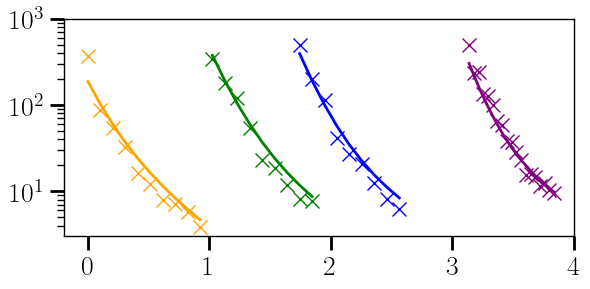

In [8]:
with open('g-1l2brange.json') as f:
    datag1 = json.load(f)
with open('g15-2l2brange.json') as f:
    datag15 = json.load(f)
with open('g2-1l2brange.json') as f:
    datag2 = json.load(f)
with open('g4-1l2brange.json') as f:
    datag4 = json.load(f)
with open('g5-1l2brange.json') as f:
    datag5 = json.load(f)
with open('g6-1l2brange.json') as f:
    datag6 = json.load(f)

datag1 = process_data(datag1)
datag15 = process_data(datag15)
datag2 = process_data(datag2)
datag4 = process_data(datag4)
datag5 = process_data(datag5)
datag6 = process_data(datag6)

df1 = pd.DataFrame(datag1)
df15 = pd.DataFrame(datag15)
df2 = pd.DataFrame(datag2)
df4 = pd.DataFrame(datag4)
df5 = pd.DataFrame(datag5)
df6 = pd.DataFrame(datag6)

from matplotlib import rc
rc('text', usetex=True)

plt.rcParams.update({
    'lines.linewidth': 2,       # Line thickness
    'lines.markersize': 10,     # Marker size
    'axes.linewidth': 1,        # Border thickness for axes
    'axes.titlesize': 20,       # Title font size
    'axes.labelsize': 20,       # Label font size
    'xtick.labelsize': 20,      # X-axis tick label font size
    'ytick.labelsize': 20,      # Y-axis tick label font size
    'xtick.major.size': 10,     # Length of X-axis ticks
    'xtick.major.width': 2,
    'xtick.minor.size': 5,     # Length of X-axis ticks
    'xtick.minor.width': 1,
    'ytick.major.size': 10,     # Length of X-axis ticks
    'ytick.major.width': 2,
    'ytick.minor.size': 5,     # Length of X-axis ticks
    'ytick.minor.width': 1,
    'legend.fontsize': 20,      # Legend font size
    'legend.frameon': True,     # Enable legend frame
    'legend.framealpha': 0.9,   # Legend frame transparency
    'legend.edgecolor': 'black', # Legend frame border color
})
plt.figure(figsize=(6, 3))
plt.plot(df1['b'], df1['sim_fit_time'], 'x', markerfacecolor='purple', markeredgecolor='purple', label="g=0.1")
plt.plot(df1['b'], df1['sol3_time'], color='purple')

plt.plot(df15['b'], df15['sim_fit_time'], 'x', markerfacecolor='blue', markeredgecolor='blue', label="g=0.15")
plt.plot(df15['b'], df15['sol3_time'], color='blue')

plt.plot(df2['b'], df2['sim_fit_time'], 'x', markerfacecolor='green', markeredgecolor='green', label="g=0.2")
plt.plot(df2['b'], df2['sol3_time'], color='green')

plt.plot(df4['b'], df4['sim_fit_time'], 'x', markerfacecolor='orange', markeredgecolor='orange', label="g=0.4")
plt.plot(df4['b'], df4['sol3_time'], color='orange')

#plt.plot(df5['b'], df5['sim_fit_time'], 'x', markerfacecolor='red', markeredgecolor='red', label="g=0.5")
#plt.plot(df5['b'], df5['sol3_time'], color='red')
#plt.plot(df5['b'], df5['sol4_time'], color='red', linestyle='dashed')

#plt.plot(df6['b'], df6['sim_fit_time'], 'x', markerfacecolor='purple', markeredgecolor='purple', label="g=0.6")
#plt.plot(df6['b'], df6['sol3_time'], color='purple')

plt.yscale('log')
#plt.ylabel(r'\textit{time}')
#plt.xlabel(r'\textit{b}')
#plt.legend()
plt.xlim(-0.2,4)
plt.ylim(0,1000)


plt.tight_layout()
plt.savefig('time-vs-b-grange-l2.svg', format='svg',  bbox_inches='tight')
plt.show()

In [8]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b